<a href="https://colab.research.google.com/github/kdmalc/intro-computer-vision/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELEC/COMP 447/546 Assignment 3


## General instructions
Please copy this colab notebook into your own Drive to edit. This notebook will also serve as your final submission report - please ensure that code cells run correctly, and that all non-code (text/latex) blocks are rendered correctly before submissing the file. Feel free to add any additional cells (code or text) you need. Please follow good coding, markdown, and presentation etiquette.

__Please do not use any AI tools for this assignment.__


## Submission instructions

- Before submitting, please `run-all` the code. This will re-render your entire jupyter file cell by cell to produce all the outputs.

- You are required to download the colab notebook as a `.ipynb` file and submit it to canvas. Please name your `.ipynb` file as `netid.ipynb`

- Modify the text cell on top to include your name and the names of any collaborators from this class you worked with on this assignment.

- Download a pdf of the executed colab notebook. You can use print -> save as pdf. Please name your `.pdf` file as `netid.pdf`.

- Any extra images used in the homework should also be uploaded to canvas.

- For simplicity, you can also upload a `netid.zip` file to canvas containing all solution files.

In [1]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.signal import convolve2d


In [3]:
def min_max_normalize(x): return (x - x.min())/(x.max() - x.min()) # converts 0-255 uint8 image to 0-1 floating point image. Here, the max value of the image is mapped to 1 and min value is mapped to 0.

def normalize_255(x): return x/255.0 # converts a 0-255 uint8 image to a floating 0-1 image by dividing by 255. Here, the images are consistently divided by 255.0 (max achievable value in an 8-bit image)

def show_image(image, title="", dpi=150, axis='off', cmap=None):
    im = image.copy()
    plt.figure(dpi=dpi)
    plt.imshow(im, cmap=cmap)
    plt.axis(axis)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def show_image_subplot(images : list[np.ndarray], num_rows: int, num_cols: int,
                       titles: list[str] = [], axis: str = 'off' , dpi: int = 80,
                       cmap: str | None = None) -> None:
    """ shows a matplotlib subplot for multiple images"""
    assert num_rows > 1 or num_cols > 1 , "Please ensure that you have more than 1 row or col"
    assert len(images) == int(num_rows*num_cols), "Please ensure that number of images provided match rows x cols product"
    titles = titles + ["No Title" for _ in range(len(images)-len(titles))] if len(titles) < len(images) else titles[:len(images)]
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, dpi=dpi)
    axs_flat = axs.flatten()
    for (_ax, _im, _title) in zip(axs_flat, images, titles):
        _ax.imshow(_im, cmap=cmap)
        _ax.axis(axis)
        _ax.set_title(_title)
    plt.tight_layout()
    plt.show()

def gaussian2D(sigma: tuple[float, float], kernel_size: tuple[int, int]) -> np.ndarray:
    """
    sigma: a tuple of x, y scales (standard deviations)
    kernel_size: a tuple of x, y dimensions of the kernel

    returns a 2D gaussian blur kernel
    """
    # Create the kernel: +/- x/2 on either side from center, same for +/- y/2
    x = np.linspace(-(kernel_size[0]//2), kernel_size[0]//2, kernel_size[0])
    y = np.linspace(-(kernel_size[1]//2), kernel_size[1]//2, kernel_size[1])
    x, y = np.meshgrid(x, y)

    # Compute the Gaussian function
    kernel = (1 / (2 * np.pi * sigma[0] * sigma[1])) * np.exp(
        -((x**2) / (2 * sigma[0]**2) + (y**2) / (2 * sigma[1]**2))
    )
    kernel /= np.sum(kernel)
    return kernel


# BASIC IMAGE PROCESSING FUNCTIONALITY FROM HW1!

def read_image(filename, grayscale=True) -> np.ndarray:
    if grayscale:
      image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      image = cv2.imread(filename)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Initial image shape: {image.shape}")
    return image

def resize_image(image :np.ndarray, size: tuple) -> np.ndarray :
    resized_image = cv2.resize(image, size)
    return resized_image

def blur(image, sigma):
  ks_x = int(3*sigma[0] * 2)
  ks_y = int(3*sigma[1] * 2)
  kernel_size = (ks_x, ks_y)
  my_kernel = gaussian2D(sigma, kernel_size)

  image = min_max_normalize(image.astype(np.float32))

  if len(image.shape)==3: # Process RGB channels
      blurred_channels = []
      # Process the 3 color channels separately, then stack them back together to form another image with len(shape)==3
      for c in range(image.shape[2]):
          channel = image[:, :, c]
          blurred_ch = convolve2d(channel, my_kernel, mode="same", boundary="symm")
          blurred_channels.append(min_max_normalize(blurred_ch))
      blurred_image = np.stack(blurred_channels, axis=2)
  else: # Process grayscale (eg 2D)
      blurred_image = min_max_normalize(convolve2d(image, my_kernel, mode="same", boundary="symm"))
      blurred_image = convolve2d(image, my_kernel, mode="same", boundary="symm")

  return blurred_image

def gausspyr(I: np.ndarray, n_levels: int, sigma: float):
    I = min_max_normalize(I.astype(np.float32))
    gaussian_pyramid_lst = [I]
    for level in range(n_levels-1):
      blurred_image = blur(gaussian_pyramid_lst[level], (sigma, sigma))
      level_image = blurred_image[::2, ::2]
      gaussian_pyramid_lst.append(level_image)
    return gaussian_pyramid_lst


## 1.0 Implement the Lucas-Kanade algorithm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this problem, you will implement the Lucas-Kanade algorithm and demonstrate tracking points
on a video

In [ ]:
"""
Some helper functions that are optional to use.

"""

def read_video_into_numpy(filename):
  cap = cv2.VideoCapture(filename)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

  cap.release()
  video = np.stack(frames, axis=0)#converts to numpy array(T,H,W,C)
  video = np.transpose(video, (1,2,3,0))#(T,H,W,C)->(H,W,C,T)
  return frames

In [ ]:
def detect_corners(img):
  dst = cv2.cornerHarris(img, 2, 3, 0.04)
  y,x = np.where(dst > 0.1*dst.max()) # tuple of locations
  return x, y

In [ ]:
# Two options for calculating image derivatives

def image_derivatives(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Sobel filters for x and y derivatives
    sobel_x = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                         [ 0,  0,  0],
                         [ 1,  2,  1]])
    # Compute derivatives using convolution
    Ix = cv2.filter2D(image, -1, sobel_x)  # Convolve with Sobel X
    Iy = cv2.filter2D(image, -1, sobel_y)  # Convolve with Sobel Y
    return Ix, Iy

def image_derivatives_numpy(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    Ix, Iy = np.gradient(image)  # Solve directly
    return Ix, Iy


In [ ]:
### Your code starts here ###

# Read the video into frames
frames = read_video_into_numpy('your video.mp4')


# Implement Lucas-Kanade
def lucas_kanade(imA, imB, points_matrix_A, L=5, sigma=3.0, K=10):
  N = points_matrix_A.shape[0]
  points_matrix_B = np.zeros_like(points_matrix_A)
  # 1) Construct L-level Gaussian pyramids for A and B
  gausspyrA = gausspyr(imA, L, sigma)
  gausspyrB = gausspyr(imB, L, sigma)
  # 2) Initialize flow guess for all points to 0
  F = np.zeros_like(points_matrix_A)
  for l in range(L-1, -1, -1):
    # a) Calculate spatial derivatives (Ax, Ay) of A^l
    # b) Location of points in this level:
    # p_A^l = p_A/2^l
    for i in range(N):
      #p = px, py = p_A^l[i, :]
      # G = big equation...
      invG = np.linalg.inv(G)
      # For K iterations,a pply LK refinement:
      for k in range(1, K+1):
        # b = big equation
        F[i, :] += invG*b
    if l<0:
      F *= 2  # Optical flow guess for next level
  points_matrix_B = points_matrix_A + F
  return points_matrix_B

In [ ]:
# Save the gif
import imageio
imageio.mimsave('tracking.gif', im_list, fps=10)  # im_list is a list of your output images

## 4.0 Image Compression with PCA

In this problem, you will use PCA to compress images, by encoding small patches in low-
dimensional subspaces.

### 4.1 Use PCA to model patches

In [10]:
"""
Some helper functions that are optional to use.

"""

# Sample patches from the image
def get_patches(img, patch_size=16, n_patches=1000, overlap=True):
  h, w, c = img.shape
  patches = np.zeros((n_patches, patch_size * patch_size * 3))
  for i in range(n_patches):
    x = np.random.randint(0, w - patch_size)
    y = np.random.randint(0, h - patch_size)

    patch = img[y:y+patch_size, x:x+patch_size, :].reshape((1, -1))

    patches[i, :] = patch
  if not overlap:
    patches = []
    for i in range(0, h, patch_size):
      for j in range(0, w, patch_size):
        if i<=h-patch_size and j<w-patch_size:
          patch = img[i:i+patch_size, j:j+patch_size, :].reshape((-1,))
          patches.append(patch)

    patches = np.asarray(patches)

  return patches

Initial image shape: (678, 1020, 3)


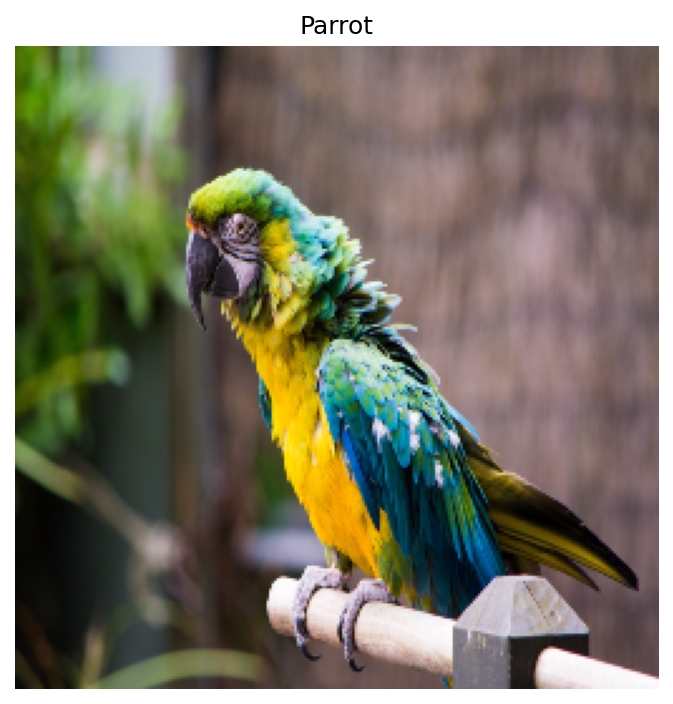

In [12]:
parrot_png = resize_image(read_image('/content/drive/My Drive/ELEC546/HW3/parrot.png', grayscale=False), (256, 256))
show_image(parrot_png, title="Parrot")

Initial image shape: (678, 1020, 3)


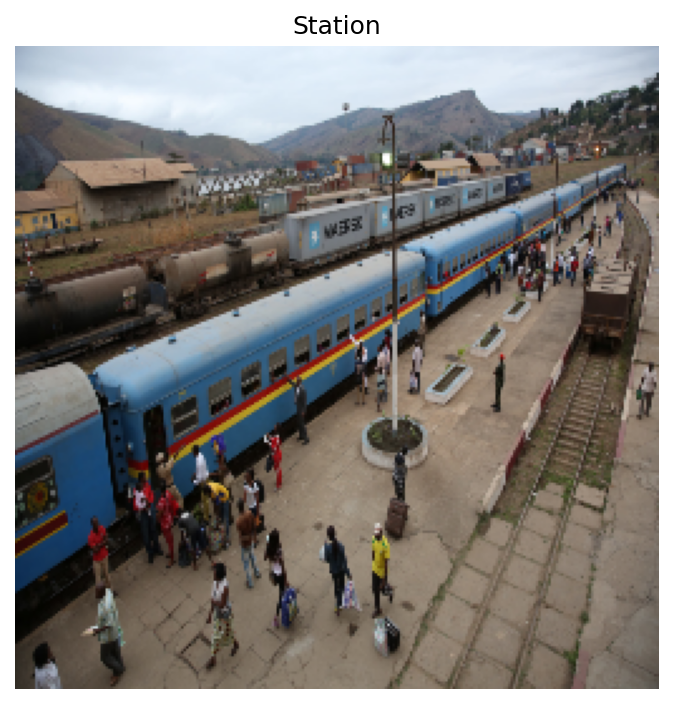

In [13]:
station_png = resize_image(read_image('/content/drive/My Drive/ELEC546/HW3/station.png', grayscale=False), (256, 256))
show_image(station_png, title="Station")

In [53]:
from numpy.linalg import svd


def pca_svd(X, k=None):
    """ Perform PCA using SVD and return the top k components."""

    ## Please write your own code to perform PCA.
    ## You may use numpy.linalg.eigh, or numpy.linalg.svd to obtain eigenvectors.

    X = X.astype(np.float32)
    # standardize first?? at least mean subtract
    # (X - mean(X)) / std(X)
    mean_X = np.mean(X, axis=0).astype(np.float32)
    X_ms = X - mean_X

    # Get eigenvectors V of C = X_0^T X_0
    # To represent X with K dimensions: Z_k = X V_k
    # To reconstruct: X = Z_k V_k^T + mean_x
    U, S, Vt = svd(X_ms, full_matrices=False)
    explained_variance = (S**2) / np.sum(S**2)

    # Select k driving components
    if k is not None:
      Vt = Vt[:k, :]

    Vt = Vt.astype(np.float32)
    return Vt, mean_X, explained_variance

def reconstruct(img: np.ndarray, k: int, num_patches=1000) -> np.ndarray:
    patch_size = 16
    patches = get_patches(img, patch_size=patch_size, n_patches=num_patches, overlap=False)
    X = patches.reshape(patches.shape[0], -1)  # Flatten patches

    #reconstructed_patches = []
    ## TODO: I think this isn't quite true, I am not sure how patches and k relate
    ## Eg I don't think changing k changes the number of patches... it just makes each patch worse
    ## So patches should probably be deterministic... need to review this
    reconstructed_image = np.zeros_like((k, k))

    for x in X:
        ## Perform PCA on the individual patch
        #pca = PCA(n_components=k)
        #Z_k = pca.fit_transform(x.reshape(1, -1))  # Project patch to lower dim
        #X_reconstructed = pca.inverse_transform(Z_k)  # Reconstruct
        #X_reconstructed = min_max_normalize(X_reconstructed)  # Normalize

        Vt, mean_X, explained_variance = pca_svd(X)
        # Ensure everything is float32 to maintain precision
        X = X.astype(np.float32)
        # Project to lower dimension
        Z_k = X @ Vt[:k, :].T
        # Reconstruct from k principal components
        X_reconstructed = min_max_normalize(Z_k @ Vt[:k, :] + mean_X)

        reconstructed_patches.append(X_reconstructed.flatten())

    # Convert list of reconstructed patches back into a numpy array
    reconstructed_patches = np.array(reconstructed_patches)

    # Reshape into an image (assuming non-overlapping patches)
    ## Is this strictly true? Are new_h and new_w correct...
    h, w, c = img.shape
    new_h = h // patch_size * patch_size
    new_w = w // patch_size * patch_size
    ## I think my patches don't make sense below:
    ## Namely I don't think it should be 4D for each color?
    ## This tries to set each "superpixel" as a patch, hence 4D
    ## I think I actually want it to be 2D (for each color), so need to reshape or something...
    X_reconstructed = reconstructed_patches.reshape((new_h // patch_size, new_w // patch_size, patch_size, patch_size, c))
    X_reconstructed = X_reconstructed.swapaxes(1, 2).reshape(new_h, new_w, c)  # Rearrange patches

    return X_reconstructed

def visualize_components(Vt, patch_size=16, n_comps_to_plot=36, num_channels=3):
    # Infer the correct patch size from Vt.shape[1]
    num_features = Vt.shape[1]
    patch_size = int(np.sqrt(num_features // num_channels))
    # Check if the patch size is valid
    if patch_size * patch_size * num_channels != num_features:
        raise ValueError(f"Patch size inference failed. Expected {num_features} to be 16x16x{num_channels} or similar.")

    # Create a 6x6 grid of the first 36 principal components
    fig, axes = plt.subplots(6, 6, figsize=(10, 10))
    for i, ax in enumerate(axes.ravel()):
        if i >= n_comps_to_plot:
            break
        # Reshape correctly and convert to grayscale (if necessary)
        patch = Vt[i].reshape((patch_size, patch_size, num_channels))
        ax.imshow(min_max_normalize(patch))  #, cmap='gray'
        ax.axis('off')
    plt.show()


def plot_variance_explained(explained_variance):
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(explained_variance) * 100, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Percent Variance Explained')
    plt.title('Explained Variance by Principal Components')
    # Get current axis and remove top/right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


In [54]:
### Your code starts here ###

# Load test image
img = parrot_png

# Get patches from image
patches = get_patches(img, patch_size=16, n_patches=1000, overlap=True)

# Implement PCA on the patches
X = patches.reshape(patches.shape[0], -1)  # Flatten patches
Vt, mean_X, explained_variance = pca_svd(X)

# Display the first 36 principal components
## Display the first 36 principal components as 16 x 16 images, arranged in a 6 x 6 grid
## (Note: remember to sort your eigenvalues and eigenvectors by decreasing eigenvalue magnitude!).
## Also report the % of variance captured by all principal components (not just the first 36) in a plot,
## x-axis being the component number, and y-axis being the % of variance explained by that component.



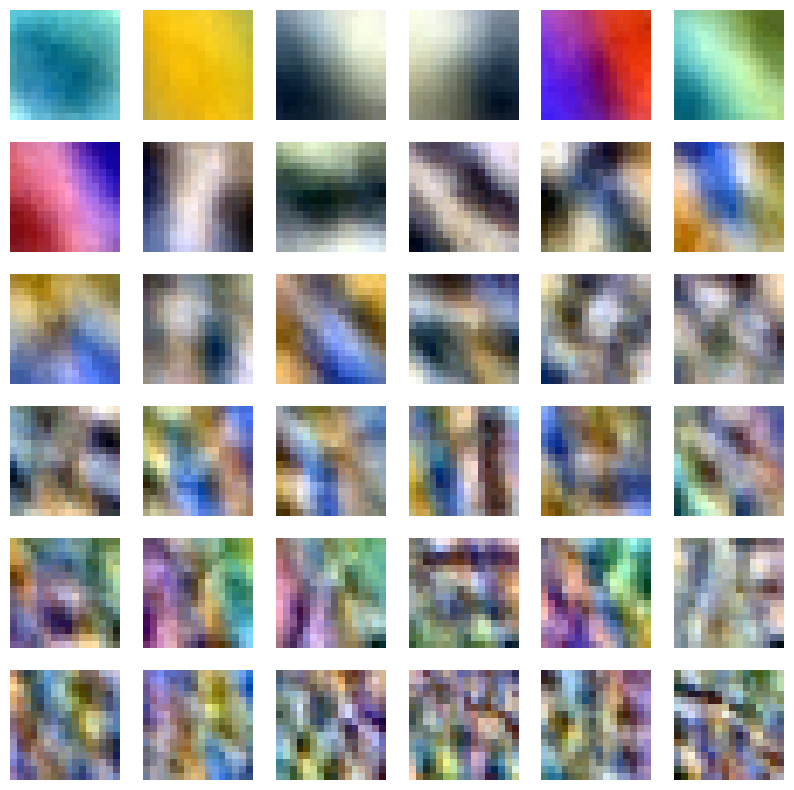

In [55]:
visualize_components(Vt[:36], patch_size=16)


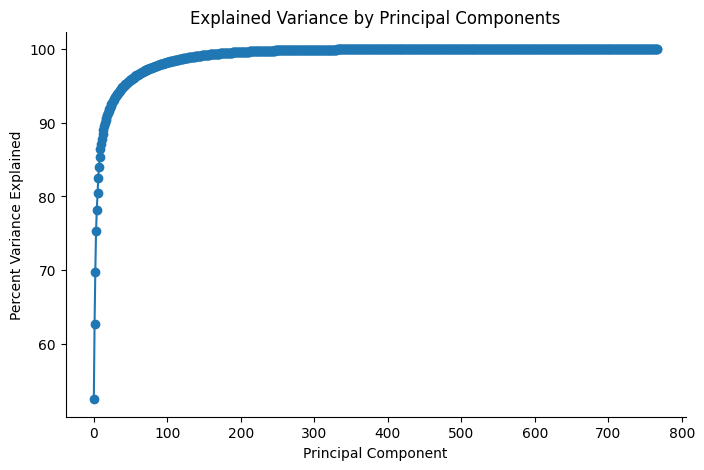

In [56]:
plot_variance_explained(explained_variance)

### 4.2 Compress the image

In [57]:
patches.shape

(1000, 768)

In [59]:
### Your code starts here ###

# Image reconstruction
## Show image reconstruction results using 1, 3, 10, 50, and 100 principal components.

k=1
X_reconstructed = reconstruct(img, k)
show_image(X_reconstructed, title=f"k={k}")

ValueError: cannot reshape array of size 44236800 into shape (16,16,16,16,3)

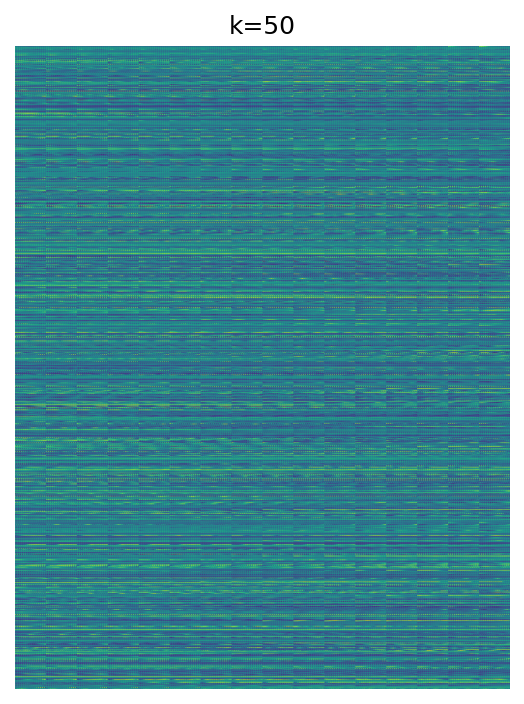

In [46]:
k=50
X_reconstructed =  reconstruct(parrot_png, k)
show_image(X_reconstructed, title=f"k={k}")

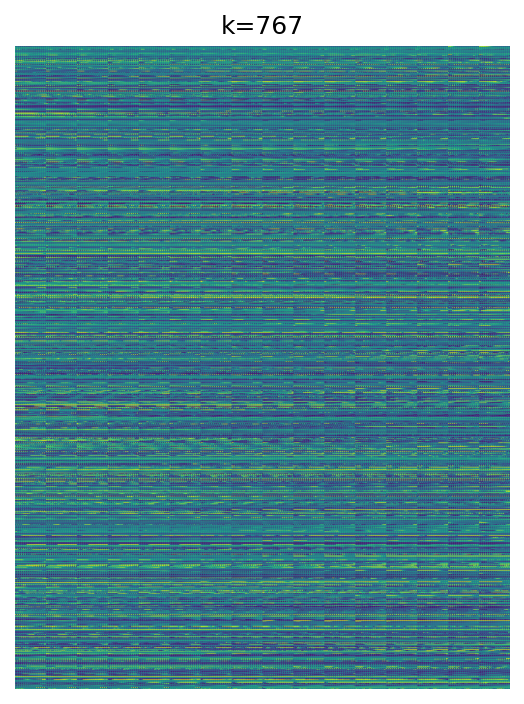

In [48]:
k=767
X_reconstructed =  reconstruct(X, Vt, mean_X, k)
show_image(X_reconstructed, title=f"k={k}")